In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../methods')

## Data generation
Use predefined concentric circles model

In [35]:
from models import ConcentricCirclesMixture

random_state = 2022

p = 100        # Number of features
a = 2        # Signal amplitude
model = ConcentricCirclesMixture(p, a, random_state=random_state)
purity = 0.5      # Proportion of inliers
n = 1000          # Number of observations

n_test = 1000     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 500.
Number of outliers in training/calibration data: 500.
Number of inliers in test data: 500.
Number of outliers in test data: 500.


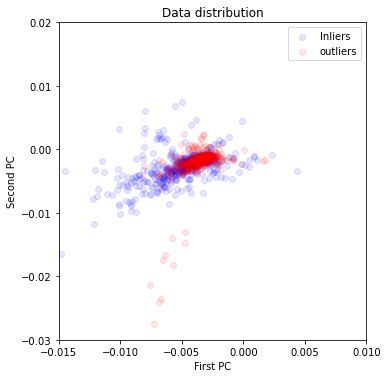

In [38]:
## Perform nonlinear PCA on an independent set of clean data
from sklearn.decomposition import KernelPCA

X_clean, _ = model.sample(n, purity=1)

pca = KernelPCA(kernel="rbf", n_components=2, gamma=0.01)
pca.fit(X_clean)

## Apply the nonlinear PCA separately to the inliers and outliers
X_in = X[Y==0]
pcs_in = pca.transform(X_in)

X_out = X[Y==1]
pcs_out = pca.transform(X_out)

## Plot the PCA results
fig, axs = plt.subplots(1,1, figsize=(5,5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs.scatter(pcs_in[:,0], pcs_in[:,1], alpha=0.1, color="blue",label="Inliers")
axs.scatter(pcs_out[:,0], pcs_out[:,1], alpha=0.1, color="red",label="outliers")  
axs.set_xlim([-0.015,0.01])
axs.set_ylim([-0.03, 0.02])
axs.set_xlabel("First PC")
axs.set_ylabel("Second PC")
axs.set_title('Data distribution')
axs.legend()
plt.show()

## Benchmark methods
Here we consider two basic benchmarks:
1. conformal p-values via binary classification
2. conformal p-values via one-class classification

Fitting the black-box model on 250 inliers and 500 outliers... done.
Calculating conformity scores for 250 hold-out inliers... done.
Calculating conformity scores for 1000 test points... done.


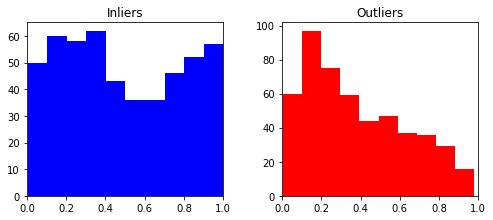

In [47]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Define list of possible two-class classifiers with desired hyper-parameters
bbox_bc_list = [RandomForestClassifier(random_state=random_state),
                KNeighborsClassifier(),
                SVC(probability=True),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),   
                MLPClassifier(max_iter=500, random_state=random_state) 
               ]

# Choose a binary classifier algorithm
bbox_bc = bbox_bc_list[0]

from methods_split import BinaryConformal

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values via binary classification
method_binary = BinaryConformal(X_in, X_out, bbox_bc, calib_size=0.5, random_state=29)
pvals_binary = method_binary.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

Fitting the black-box model on 250 data points... done.
Calculating conformity scores for 250 hold-out data points... done.
Calculating conformity scores for 1000 test points... done.


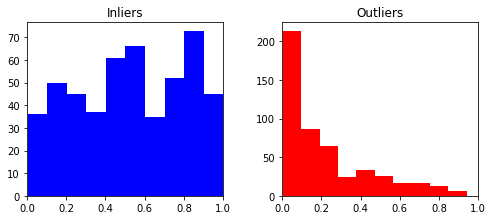

In [43]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf'),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[3]

from methods_split import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values via one-class classification
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## New approach: Integrative conformal p-values 
Our new integrative conformal p-values will be able to automatically choose and tune the best model. Moreover, it is able to produce more powerful results by extracting more information from the calibration set using weighted p-values. See the accompanying paper for more details.

Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a two-class classification model on 500 data points... done.
Fitting a two-class classification model on 500 data points... done.
Fitting a two-class classification model on 500 data points... done.
Fitting a two-class classification model on 500 data points... done.
Fitting a two-class classification

100%|██████████| 1000/1000 [00:08<00:00, 121.37it/s]


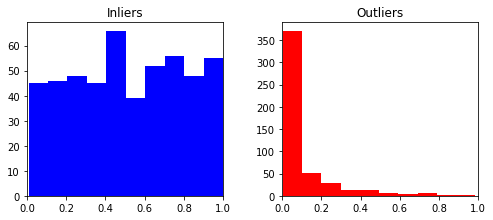

In [44]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list
bboxes_two = bbox_bc_list

# Compute the p-values
method_int = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, bboxes_two=bboxes_two,
                                       calib_size=0.5, tuning=True)
pvals_int, pvals_int_0, pvals_int_1 = method_int.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Compare all p-values by qq-plot


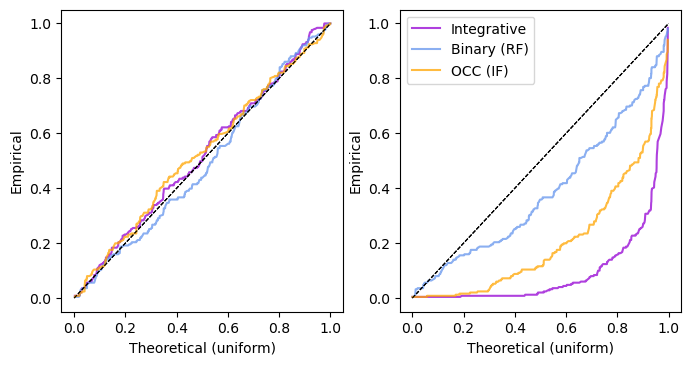

In [48]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_int[Y_test==y], U[Y_test==y], axs[y], label="Integrative", color='#9400d3',
            logarithm=logarithm)
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (RF)", color="#6495ED",
            logarithm=logarithm)
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (IF)", color='#FFA500',
            logarithm=logarithm)

plt.legend()
plt.show()